# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc.pilutil import imread, imresize
import datetime
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import keras
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data'+'/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data'+'/val.csv').readlines())
batch_size = 30 # setting the batch size to 30 

In [4]:
# training data
Nfolders = 663 # number of folders in training data
Images_folder = 30 # number of images per folder in training data
Skip_size = 3 # to esnure that we consider only 6 images out of 30 images per folder for img_idx

image_size = (60, 80, 3) # image size to be considered for standardization

length = image_size[0]
height = image_size[1]

Nframes = int(Images_folder / Skip_size) # number of frames for img_idx

Nframes

10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,Images_folder,Skip_size))#create a list of image numbers you want to use for a particular video
    x = len(img_idx) #no of images we will consider for one video
    image_size = (60,80,3) #since the images are of different sizes we have considered 60x80 as the standard size
    y = image_size[0]
    z = image_size[1]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image, (y,z) ) # resizing all images to 120X160 size
                    image0 = image[:,:,0] 
                    image1 = image[:,:,1] 
                    image2 = image[:,:,2]
                    
                    image0 = (image0 - np.min(image0)) / (np.max(image0) - np.min(image0))
                    image1 = (image1 - np.min(image1)) / (np.max(image1) - np.min(image1))
                    image2 = (image0 - np.min(image2)) / (np.max(image2) - np.min(image2))
                    
                    batch_data[folder,idx,:,:,0] = image0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image2 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        batch_size_leftover = len(folder_list) - num_batches*batch_size # batches left for processing
        batch_data = np.zeros((batch_size_leftover,x,y,z,3)) ## x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((batch_size_leftover,5)) # batch_labels is the one hot representation of the output
        for folder in range(batch_size_leftover): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size_leftover)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (num_batches*batch_size_leftover)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = imresize(image,image_size[0:2] ) # resizing all images to 120X160 size
                image0 = image[:,:,0] 
                image1 = image[:,:,1] 
                image2 = image[:,:,2]
                    
                image0 = (image0 - np.percentile(image0,10)) / (np.percentile(image0,90) - np.percentile(image0,10))
                image1 = (image1 - np.percentile(image1,10)) / (np.percentile(image1,90) - np.percentile(image1,10))
                image2 = (image2 - np.percentile(image2,10)) / (np.percentile(image2,90) - np.percentile(image2,10))
                    
                batch_data[folder,idx,:,:,0] = image0 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = image1 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = image2 #normalise and feed in the image
                
            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data'+'/train'
val_path = 'Project_data'+'/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

#### Model1 - Conv3D architecture - variant 1 -  number of features kept lower - 16 each for conv layers. used drop outs. No BN. No Max pooling.

In [9]:
input_shape = (Nframes, length, height, 3)
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D1'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D2'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.Adadelta()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 16)    1312      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 80, 16)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60, 80, 16)    0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 10, 60, 80, 16)    6928      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 60, 80, 16)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 60, 80, 16)    0         
_________________________________________________________________
Conv3D2 (Conv3D)             (None, 10, 60, 80, 16)    6928      
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.20,min_delta=0,verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 30
Epoch 1/20
 ; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 30s 1s/step - loss: 3.0632 - categorical_accuracy: 0.2143 - val_loss: 1.6483 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2021-01-0207_01_33.779426/model-00001-3.11833-0.20965-1.64834-0.25000.h5
Epoch 2/20
23/23 [==============================] - 24s 1s/step - loss: 1.6539 - categorical_accuracy: 0.2410 - val_loss: 1.5662 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init_2021-01-0207_01_33.779426/model-00002-1.59689-0.25038-1.56622-0.19000.h5
Epoch 3/20
23/23 [==============================] - 25s 1s/step - loss: 1.6030 - categorical_accuracy: 0.2831 - val_loss: 1.5766 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2021-01-0207_01_33.779426/model-00003-1.58317-0.29412-1.57660-0.25000.h5
Epoch 4/20
23/23 [==============================] - 25s 1s/step - loss: 1.4801 - categorical_accuracy: 0.3528 - val_loss: 1.5073 - val_categorical_accuracy: 0.2800

Epoch 00004:

In [16]:
def plot_model_metrics(data):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data.history['categorical_accuracy'])
    plt.plot(data.history['val_categorical_accuracy'])
    plt.legend(["categorical_accuracy",'val_categorical_accuracy'])

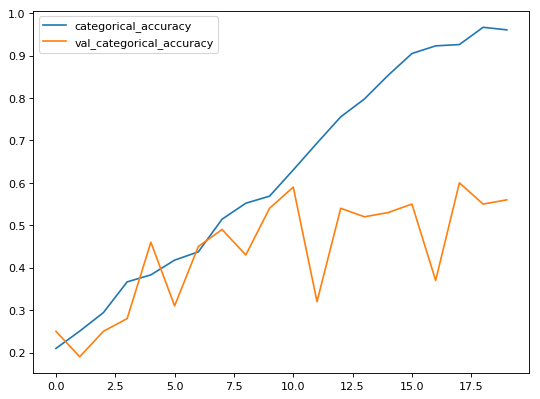

In [29]:
plot_model_metrics(model.history)

#### Inference - Model is clearly overfitting.

#### Model1 - Conv3D architecture - variant 2 - increasing the number of layers. Learning rate = 0.05

In [15]:
input_shape = (Nframes, length, height, 3)
num_classes = 5

model1 = Sequential()

model1.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D1'))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D2'))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D3'))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

In [16]:
optimiser = optimizers.Adadelta(lr=0.05)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 16)    1312      
_________________________________________________________________
activation_6 (Activation)    (None, 10, 60, 80, 16)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 60, 80, 16)    0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 10, 60, 80, 16)    6928      
_________________________________________________________________
activation_7 (Activation)    (None, 10, 60, 80, 16)    0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 60, 80, 16)    0         
_________________________________________________________________
Conv3D2 (Conv3D)             (None, 10, 60, 80, 16)    6928      
__________

In [17]:
model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train Epoch 1/20
; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 35s 2s/step - loss: 1.6523 - categorical_accuracy: 0.1815 - val_loss: 1.5992 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-1.64352-0.18854-1.59924-0.22000.h5
Epoch 2/20
23/23 [==============================] - 23s 989ms/step - loss: 1.6107 - categorical_accuracy: 0.1742 - val_loss: 1.6044 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-1.60878-0.18100-1.60439-0.24000.h5
Epoch 3/20
23/23 [==============================] - 24s 1s/step - loss: 1.6036 - categorical_accuracy: 0.1940 - val_loss: 1.6047 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.59843-0.18854-1.60470-0.20000.h5
Epoch 4/20
23/23 [==============================] - 25s 1s/step - loss: 1.6019 - categorical_accuracy: 0.2317 - val_loss: 1.6022 - val_categorical_accuracy: 0.2000

Epoch 000

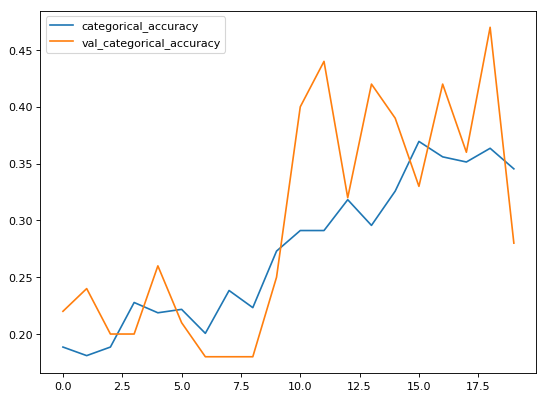

In [18]:
plot_model_metrics(model1.history)

#### Inference - Adding number of layers on a overfitted model, increased the complexity further. As a result training accuracy dropped significantly.  

#### Model1 - Conv3D architecture - variant 3 - keeping 3 layers. Adding batch normalization and max pooling. removing dropouts from CN layer. Keeping dropout in FC layer.

In [19]:
input_shape = (Nframes, length, height, 3)
num_classes = 5

model2 = Sequential()

model2.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D1'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D3'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [20]:
optimiser = optimizers.Adadelta(lr=0.05)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 16)    1312      
_________________________________________________________________
activation_12 (Activation)   (None, 10, 60, 80, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 80, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 30, 40, 16)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 16)     6928      
_________________________________________________________________
activation_13 (Activation)   (None, 5, 30, 40, 16)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 30, 40, 16)     64        
__________

In [21]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 27s 1s/step - loss: 3.2970 - categorical_accuracy: 0.2207 - val_loss: 2.0667 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-3.24565-0.22926-2.06668-0.27000.h5
Epoch 2/20
23/23 [==============================] - 24s 1s/step - loss: 2.5135 - categorical_accuracy: 0.2758 - val_loss: 1.5976 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-2.47384-0.28658-1.59759-0.34000.h5
Epoch 3/20
23/23 [==============================] - 24s 1s/step - loss: 2.3193 - categorical_accuracy: 0.3252 - val_loss: 1.8440 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-2.18344-0.33786-1.84402-0.43000.h5
Epoch 4/20
23/23 [==============================] - 25s 1s/step - loss: 1.8384 - categorical_accuracy: 0.3624 - val_loss: 1.8844 - val_categorical_accuracy: 0.4600

Epoch 00004:

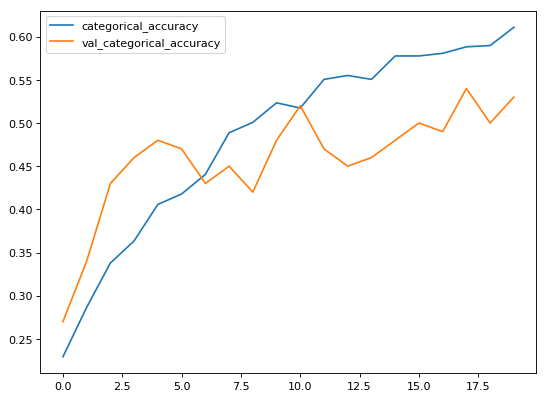

In [22]:
plot_model_metrics(model2.history)

#### Inference -  Adding Batch normalization and max pooling had a positive outcome. Also dropout in the FC layer is helping with the problem of overfitting. 

#### Model1 - Conv3D architecture - variant 4 - Use dropouts after conv and FC layers, use BN. keep learning rate @ 0.05

In [23]:
input_shape = (Nframes, length, height, 3)
num_classes = 5

model3 = Sequential()

model3.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D1'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv3D(16, (3, 3, 3), padding='same', name = 'Conv3D3'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

In [24]:
optimiser = optimizers.Adadelta(lr=0.05)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 16)    1312      
_________________________________________________________________
activation_17 (Activation)   (None, 10, 60, 80, 16)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 60, 80, 16)    64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 30, 40, 16)     0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 30, 40, 16)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 16)     6928      
_________________________________________________________________
activation_18 (Activation)   (None, 5, 30, 40, 16)     0         
__________

In [25]:
model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 26s 1s/step - loss: 4.5325 - categorical_accuracy: 0.1896 - val_loss: 1.8223 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-4.58892-0.18401-1.82234-0.36000.h5
Epoch 2/20
23/23 [==============================] - 23s 980ms/step - loss: 3.7919 - categorical_accuracy: 0.2230 - val_loss: 2.1252 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-3.78939-0.21870-2.12519-0.29000.h5
Epoch 3/20
23/23 [==============================] - 23s 1s/step - loss: 3.3994 - categorical_accuracy: 0.2047 - val_loss: 1.8645 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-3.32764-0.21267-1.86454-0.39000.h5
Epoch 4/20
23/23 [==============================] - 23s 992ms/step - loss: 2.9542 - categorical_accuracy: 0.2352 - val_loss: 1.8218 - val_categorical_accuracy: 0.3200

Epoch 

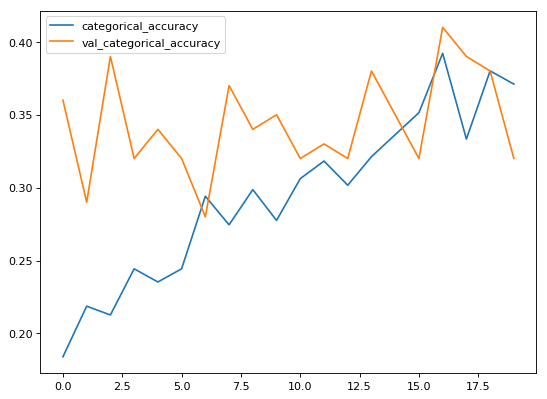

In [26]:
plot_model_metrics(model3.history)

#### Inference - Model performance deteroriated after inserting Dropout and BN after every layer. 

#### Model1 - Conv3D architecture - variant 5 - Increasing number of features . BN applied. dropout only in FC layer. keeping learning rate @ 0.05. increased number of epochs.

In [28]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 50

model4 = Sequential()

model4.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))


model4.add(Conv3D(32, (3, 3, 3), padding='same', name = 'Conv3D1'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))


model4.add(Conv3D(64, (3, 3, 3), padding='same', name = 'Conv3D3'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))


model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

In [29]:
optimiser = optimizers.Adadelta(lr=0.05)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 32)    2624      
_________________________________________________________________
activation_27 (Activation)   (None, 10, 60, 80, 32)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 60, 80, 32)    128       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 5, 30, 40, 32)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 32)     27680     
_________________________________________________________________
activation_28 (Activation)   (None, 5, 30, 40, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 30, 40, 32)     128       
__________

In [30]:
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 27s 1s/step - loss: 2.5163 - categorical_accuracy: 0.2622 - val_loss: 2.1954 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-2.56845-0.25943-2.19537-0.40000.h5
Epoch 2/50
23/23 [==============================] - 23s 1s/step - loss: 1.5564 - categorical_accuracy: 0.4562 - val_loss: 2.3121 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-1.56891-0.44796-2.31205-0.44000.h5
Epoch 3/50
23/23 [==============================] - 23s 1s/step - loss: 1.1854 - categorical_accuracy: 0.5328 - val_loss: 2.4873 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.15479-0.55354-2.48734-0.41000.h5
Epoch 4/50
23/23 [==============================] - 24s 1s/step - loss: 1.0049 - categorical_accuracy: 0.6271 - val_loss: 1.7233 - val_categorical_accuracy: 0.5100

Epoch 00004:

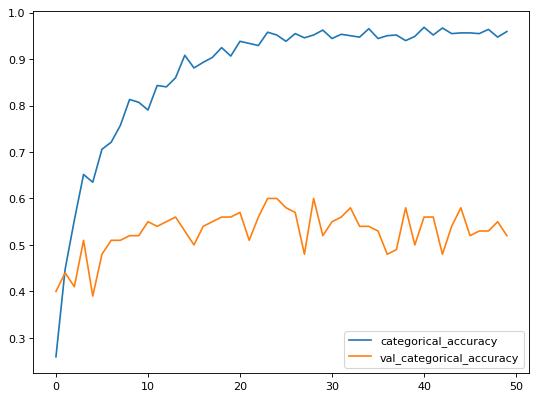

In [31]:
plot_model_metrics(model4.history)

#### Inference: as we increase number of features to 32 from 16, and remove dropout from CN layers, we observe the problem of overfitting again. 

#### Model1 - Conv3D architecture - variant 6 - Increasing number of features . BN applied. dropout in FC &CN layer. keeping learning rate @ 0.05. increased number of epochs.

In [32]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 50

model5 = Sequential()

model5.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv3D(32, (3, 3, 3), padding='same', name = 'Conv3D1'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv3D(64, (3, 3, 3), padding='same', name = 'Conv3D3'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())
model5.add(Dense(256))
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes))
model5.add(Activation('softmax'))

In [33]:
optimiser = optimizers.Adadelta(lr=0.05)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 32)    2624      
_________________________________________________________________
activation_32 (Activation)   (None, 10, 60, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 60, 80, 32)    128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 30, 40, 32)     0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 30, 40, 32)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 32)     27680     
_________________________________________________________________
activation_33 (Activation)   (None, 5, 30, 40, 32)     0         
__________

In [34]:
model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 27s 1s/step - loss: 4.0391 - categorical_accuracy: 0.2230 - val_loss: 1.8609 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-3.97730-0.21870-1.86090-0.39000.h5
Epoch 2/50
23/23 [==============================] - 23s 1s/step - loss: 2.7561 - categorical_accuracy: 0.3107 - val_loss: 1.7708 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-2.62921-0.32278-1.77078-0.44000.h5
Epoch 3/50
23/23 [==============================] - 24s 1s/step - loss: 1.9722 - categorical_accuracy: 0.3362 - val_loss: 1.8116 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.94901-0.33635-1.81161-0.47000.h5
Epoch 4/50
23/23 [==============================] - 24s 1s/step - loss: 1.8844 - categorical_accuracy: 0.3455 - val_loss: 1.4350 - val_categorical_accuracy: 0.5500

Epoch 00004:

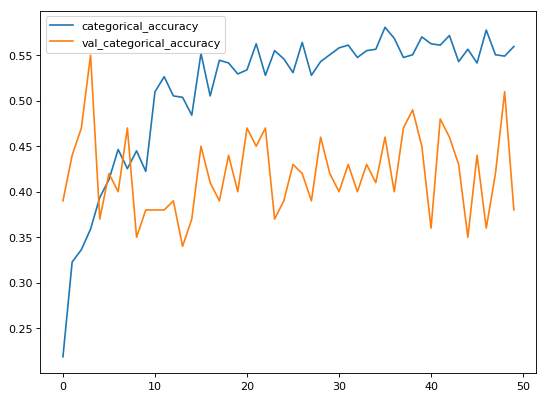

In [35]:
plot_model_metrics(model5.history)

#### Inference: Adding dropout in every layer, even with higher number of features, has the same outcome.. drastic reduction in the ability to learn the training data

#### Model1 - Conv3D architecture - variant 7 - BN applied. dropout reduced in FC & CN layer. Dropout removed from input layer. keeping learning rate @ 0.01. increased number of epochs.

In [70]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 40

model6 = Sequential()

model6.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))


model6.add(Conv3D(32, (3, 3, 3), padding='same', name = 'Conv3D1'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.15))

model6.add(Conv3D(64, (3, 3, 3), padding='same', name = 'Conv3D3'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Dropout(0.20))

model6.add(Flatten())
model6.add(Dense(256))
model6.add(Activation('relu'))
model6.add(Dropout(0.5))
model6.add(Dense(num_classes, ))
model6.add(Activation('softmax'))

In [71]:
optimiser = optimizers.Adadelta(lr=0.01)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 32)    2624      
_________________________________________________________________
activation_37 (Activation)   (None, 10, 60, 80, 32)    0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 10, 60, 80, 32)    128       
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 5, 30, 40, 32)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 32)     27680     
_________________________________________________________________
activation_38 (Activation)   (None, 5, 30, 40, 32)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 5, 30, 40, 32)     128       
__________

In [72]:
model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 27s 1s/step - loss: 4.2065 - categorical_accuracy: 0.1954 - val_loss: 2.3803 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-4.21841-0.19005-2.38029-0.23000.h5
Epoch 2/40
23/23 [==============================] - 21s 895ms/step - loss: 3.5100 - categorical_accuracy: 0.2105 - val_loss: 1.9298 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-3.54383-0.21870-1.92976-0.34000.h5
Epoch 3/40
23/23 [==============================] - 23s 1s/step - loss: 3.3771 - categorical_accuracy: 0.2265 - val_loss: 1.9083 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-3.31868-0.23529-1.90826-0.30000.h5
Epoch 4/40
23/23 [==============================] - 24s 1s/step - loss: 3.3027 - categorical_accuracy: 0.2303 - val_loss: 1.7752 - val_categorical_accuracy: 0.3200

Epoch 000

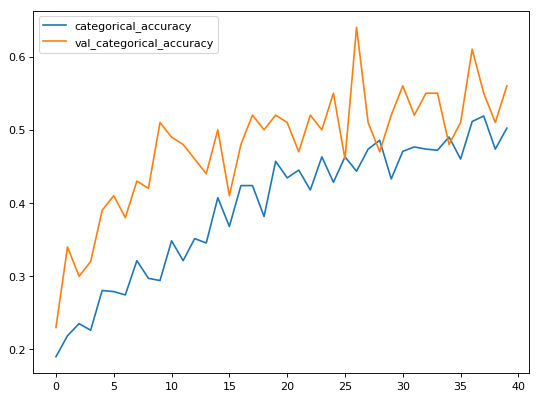

In [73]:
plot_model_metrics(model6.history)

#### Inference: Very slow improvement in training and validation accuracy. However, good to see them increasing together. 

#### Model2 - Conv2D + RNN architecture - variant 1 - basic model - 16 feature each in the Conv2D layers

In [11]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import TimeDistributed

In [42]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 20

# model below

model20 = Sequential()

model20.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model20.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model20.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model20.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model20.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model20.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model20.add(TimeDistributed(Flatten()))

model20.add(Dense(128, activation='relu'))
model20.add(Dropout(0.5))


## GRU + Softmax.
model20.add(GRU(256, return_sequences=False))
model20.add(Dense(num_classes, activation='softmax'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 10, 60, 80, 16)    448       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 30, 40, 16)    2320      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 15, 20, 16)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 15, 20, 16)    2320      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 8, 10, 16)     0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 1280)          0         
__________

In [43]:
optimiser = optimizers.Adadelta(lr=0.05)
model20.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model20.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 10, 60, 80, 16)    448       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 10, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 10, 30, 40, 16)    2320      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 15, 20, 16)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 15, 20, 16)    2320      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 8, 10, 16)     0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 10, 1280)          0         
__________

In [44]:
model20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 27s 1s/step - loss: 1.6048 - categorical_accuracy: 0.2288 - val_loss: 1.5996 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-1.60431-0.22474-1.59961-0.23000.h5
Epoch 2/20
23/23 [==============================] - 22s 964ms/step - loss: 1.6043 - categorical_accuracy: 0.2090 - val_loss: 1.6127 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-1.60215-0.21719-1.61272-0.22000.h5
Epoch 3/20
23/23 [==============================] - 23s 1s/step - loss: 1.5904 - categorical_accuracy: 0.2486 - val_loss: 1.5913 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.59582-0.23228-1.59128-0.21000.h5
Epoch 4/20
23/23 [==============================] - 24s 1s/step - loss: 1.5998 - categorical_accuracy: 0.2215 - val_loss: 1.5865 - val_categorical_accuracy: 0.2800

Epoch 000

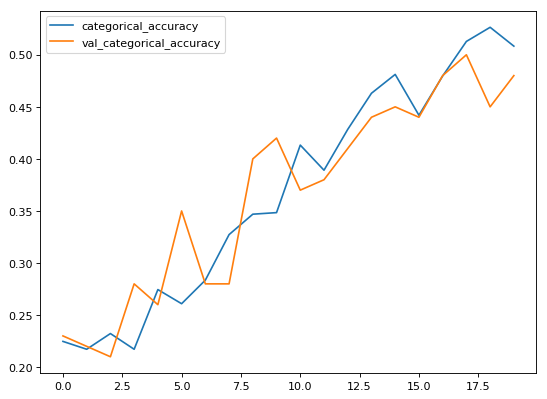

In [45]:
plot_model_metrics(model20.history)

#### Inference - Model performance is .5 after 20 epochs. with increase in number of epochs we might observe improvement. however, good to see validation accuracy catching up with training accuracy, consistently. 

#### Model2 - Conv2D + RNN architecture - variant 2 - adding one layer. Increasing epochs.

In [46]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 30

# model below

model21 = Sequential()

model21.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model21.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model21.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model21.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model21.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model21.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model21.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model21.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model21.add(TimeDistributed(Flatten()))

model21.add(Dense(128, activation='relu'))
model21.add(Dropout(0.5))


## GRU + Softmax.
model21.add(GRU(256, return_sequences=False))
model21.add(Dense(num_classes, activation='softmax'))

In [47]:
optimiser = optimizers.Adadelta(lr=0.05)
model21.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model21.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 10, 60, 80, 16)    448       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 10, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 30, 40, 16)    2320      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 15, 20, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 15, 20, 16)    2320      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 8, 10, 16)     0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 10, 8, 10, 16)     2320      
__________

In [48]:
model21.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 26s 1s/step - loss: 1.6069 - categorical_accuracy: 0.2128 - val_loss: 1.6083 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-1.60754-0.20814-1.60826-0.23000.h5
Epoch 2/30
23/23 [==============================] - 22s 970ms/step - loss: 1.6090 - categorical_accuracy: 0.1853 - val_loss: 1.6014 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-1.60845-0.17949-1.60137-0.28000.h5
Epoch 3/30
23/23 [==============================] - 23s 981ms/step - loss: 1.6026 - categorical_accuracy: 0.2201 - val_loss: 1.6047 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.60293-0.21569-1.60465-0.20000.h5
Epoch 4/30
23/23 [==============================] - 23s 1s/step - loss: 1.6012 - categorical_accuracy: 0.2157 - val_loss: 1.6019 - val_categorical_accuracy: 0.2000

Epoch 

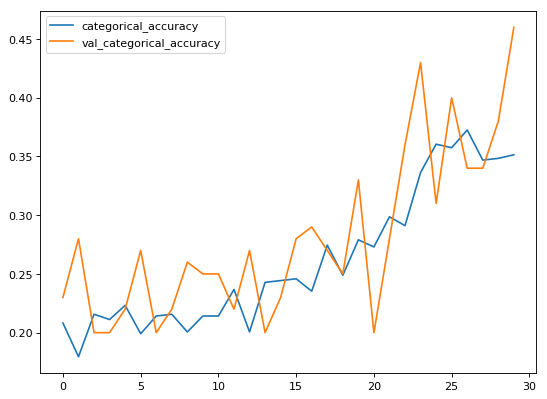

In [49]:
plot_model_metrics(model21.history)

#### Inference: Increasing the number of layers severly impacted the model performance both for training and validation data. 

#### Model2 - Conv2D + RNN architecture - variant 3 - reducing one layer and adding BN and dropout. Increasing epochs.

In [50]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 40

# model below

model22 = Sequential()

model22.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model22.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model22.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model22.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model22.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
model22.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model22.add(TimeDistributed(BatchNormalization()))
model22.add(Dropout(0.25))

model22.add(TimeDistributed(Flatten()))

model22.add(Dense(128, activation='relu'))
model22.add(Dropout(0.5))


## GRU + Softmax.
model22.add(GRU(256, return_sequences=False))
model22.add(Dense(num_classes, activation='softmax'))

In [51]:
optimiser = optimizers.Adadelta(lr=0.05)
model22.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model22.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 10, 60, 80, 16)    448       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 30, 40, 16)    2320      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 15, 20, 16)    0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 10, 15, 20, 16)    2320      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 10, 8, 10, 16)     0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 10, 8, 10, 16)     64        
__________

In [52]:
model22.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 28s 1s/step - loss: 1.6199 - categorical_accuracy: 0.2613 - val_loss: 1.4810 - val_categorical_accuracy: 0.4300

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-1.60879-0.27149-1.48102-0.43000.h5
Epoch 2/40
23/23 [==============================] - 23s 984ms/step - loss: 1.5074 - categorical_accuracy: 0.3377 - val_loss: 1.4184 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-1.50420-0.33786-1.41840-0.44000.h5
Epoch 3/40
23/23 [==============================] - 23s 1s/step - loss: 1.4180 - categorical_accuracy: 0.3850 - val_loss: 1.4111 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.40822-0.37406-1.41108-0.52000.h5
Epoch 4/40
23/23 [==============================] - 24s 1s/step - loss: 1.3168 - categorical_accuracy: 0.4402 - val_loss: 1.3781 - val_categorical_accuracy: 0.5500

Epoch 000

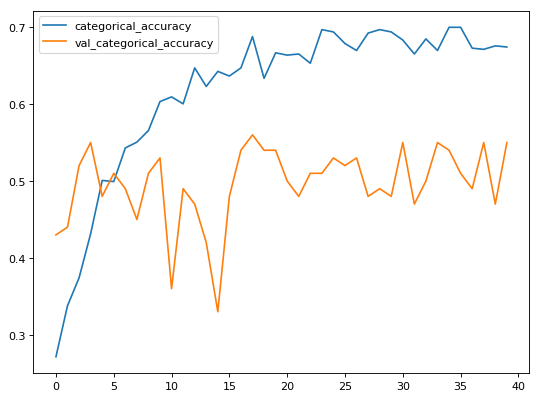

In [53]:
plot_model_metrics(model22.history)

#### Inference: Plateau observed in validation accuracy. Signs of overfitting. 

#### Model2 - Conv2D + RNN architecture - variant 4 - increasing number of features. adding BN and dropout. Increasing epochs.

In [54]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 40

# model below

model23 = Sequential()

model23.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model23.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model23.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model23.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model23.add(TimeDistributed(BatchNormalization()))
model23.add(Dropout(0.25))

model23.add(TimeDistributed(Flatten()))

model23.add(Dense(256, activation='relu'))
model23.add(Dropout(0.5))


## GRU + Softmax.
model23.add(GRU(256, return_sequences=False))
model23.add(Dense(num_classes, activation='softmax'))

In [55]:
optimiser = optimizers.Adadelta(lr=0.05)
model23.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model23.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 10, 60, 80, 16)    448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 10, 30, 40, 16)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 10, 30, 40, 32)    4640      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 10, 15, 20, 32)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 10, 15, 20, 64)    18496     
_________________________________________________________________
time_distributed_37 (TimeDis (None, 10, 8, 10, 64)     0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 10, 8, 10, 64)     256       
__________

In [56]:
model23.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 26s 1s/step - loss: 1.5493 - categorical_accuracy: 0.2918 - val_loss: 1.4525 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2021-01-0207_17_23.427000/model-00001-1.54040-0.30317-1.45248-0.41000.h5
Epoch 2/40
23/23 [==============================] - 22s 945ms/step - loss: 1.3088 - categorical_accuracy: 0.4480 - val_loss: 1.4237 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2021-01-0207_17_23.427000/model-00002-1.30208-0.45249-1.42374-0.51000.h5
Epoch 3/40
23/23 [==============================] - 23s 1s/step - loss: 1.2249 - categorical_accuracy: 0.4733 - val_loss: 1.4786 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to model_init_2021-01-0207_17_23.427000/model-00003-1.18336-0.49170-1.47862-0.48000.h5
Epoch 4/40
23/23 [==============================] - 23s 1s/step - loss: 1.0866 - categorical_accuracy: 0.5883 - val_loss: 1.5358 - val_categorical_accuracy: 0.5000

Epoch 000

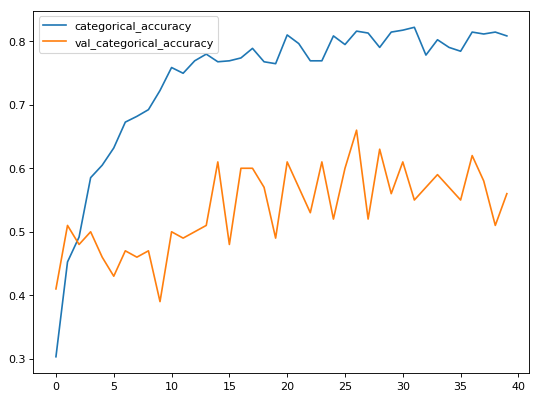

In [57]:
plot_model_metrics(model23.history)

#### Inference -  best model yet for Conv2D and RNN category. Improvement in accuracy for both training and accuracy data. Signs of overfitting. 

#### Model2 - Conv2D + RNN architecture - variant 5 - increasing number of features further. adding BN and dropout. Increasing epochs. Slight change in Architecture. 

In [12]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 40

# model below

model24d = Sequential()

model24d.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
model24d.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))

model24d.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model24d.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))
model24d.add(Dropout(0.25))

model24d.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model24d.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), padding='same')))
model24d.add(Dropout(0.25))

model24d.add(TimeDistributed(BatchNormalization()))


model24d.add(TimeDistributed(Flatten()))

## GRU + Softmax.
model24d.add(GRU(256, return_sequences=False, dropout=0.25))
model24d.add(Dense(num_classes, activation='softmax'))

In [13]:
optimiser = optimizers.Adadelta(lr=0.001)
model24d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model24d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 60, 80, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 30, 40, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 30, 40, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 15, 20, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 15, 20, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 15, 20, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 8, 10, 64)     0         
__________

In [14]:
model24d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 30
Source path =  Project_data/train ; batch size = 30Epoch 1/40



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 95s 4s/step - loss: 1.6958 - categorical_accuracy: 0.2375 - val_loss: 1.6503 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2021-01-0213_07_46.115101/model-00001-1.69598-0.23379-1.65031-0.26000.h5
Epoch 2/40
23/23 [==============================] - 22s 968ms/step - loss: 1.6891 - categorical_accuracy: 0.2549 - val_loss: 1.6940 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2021-01-0213_07_46.115101/model-00002-1.67820-0.25189-1.69400-0.21000.h5
Epoch 3/40
23/23 [==============================] - 22s 973ms/step - loss: 1.7055 - categorical_accuracy: 0.2134 - val_loss: 1.6714 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2021-01-0213_07_46.115101/model-00003-1.70646-0.22172-1.67135-0.22000.h5
Epoch 4/40
23/23 [==============================] - 22s 959ms/step - loss: 1.7078 - categorical_accuracy: 0.2564 - val_loss: 1.6892 - val_categorical_accuracy: 0.2100

Epo

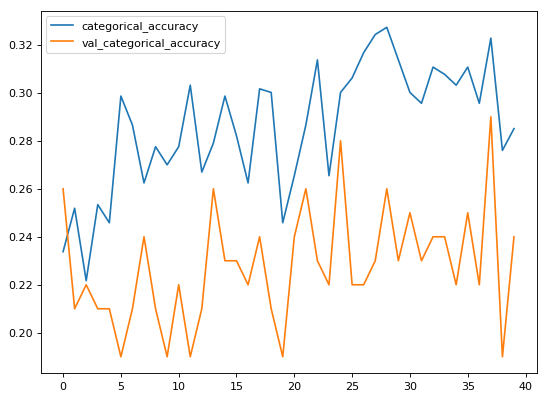

In [17]:
plot_model_metrics(model24d.history)

#### Inference: Model didn't improve despite architecture changes and feature increase. 

#### Best Models

#### Best Model suggestion- Conv3D

In [35]:
input_shape = (Nframes, length, height, 3)
num_classes = 5
num_epochs = 50

model_ = Sequential()

model_.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=input_shape, name = 'Conv3D0'))
model_.add(Activation('relu'))
model_.add(BatchNormalization())
model_.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_.add(Conv3D(32, (3, 3, 3), padding='same', name = 'Conv3D1'))
model_.add(Activation('relu'))
model_.add(BatchNormalization())
model_.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_.add(Dropout(0.15))

model_.add(Conv3D(64, (3, 3, 3), padding='same', name = 'Conv3D3'))
model_.add(Activation('relu'))
model_.add(BatchNormalization())
model_.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_.add(Dropout(0.20))

model_.add(Flatten())
model_.add(Dense(256))
model_.add(Activation('relu'))
model_.add(Dropout(0.5))
model_.add(Dense(num_classes, ))
model_.add(Activation('softmax'))

In [36]:
optimiser = optimizers.Adadelta(lr=0.01)
model_.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 32)    2624      
_________________________________________________________________
activation_21 (Activation)   (None, 10, 60, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 60, 80, 32)    128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 30, 40, 32)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 32)     27680     
_________________________________________________________________
activation_22 (Activation)   (None, 5, 30, 40, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 5, 30, 40, 32)     128       
__________

In [37]:
model_.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/23 [=>............................] - ETA: 41s - loss: 5.4109 - categorical_accuracy: 0.2000 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


23/23 [==============================] - 27s 1s/step - loss: 4.1957 - categorical_accuracy: 0.2128 - val_loss: 2.1797 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-01-0213_07_46.115101/model-00001-4.23423-0.20814-2.17970-0.21000.h5
Epoch 2/50
23/23 [==============================] - 22s 951ms/step - loss: 3.7594 - categorical_accuracy: 0.2259 - val_loss: 2.1233 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2021-01-0213_07_46.115101/model-00002-3.73942-0.22172-2.12332-0.21000.h5
Epoch 3/50
23/23 [==============================] - 24s 1s/step - loss: 3.4689 - categorical_accuracy: 0.2294 - val_loss: 1.9758 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_2021-01-0213_07_46.115101/model-00003-3.46424-0.23831-1.97579-0.33000.h5
Epoch 4/50
23/23 [==============================] - 23s 998ms/step - loss: 3.0997 - categorical_accuracy: 0.2424 - val_loss: 1.7819 - val_categorical_accuracy: 0.2800

Epoch 

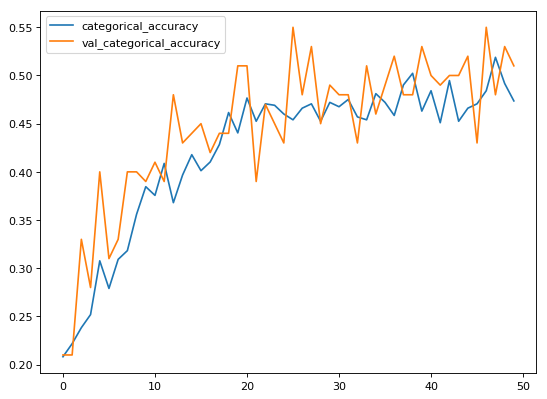

In [38]:
plot_model_metrics(model_.history)

In [39]:
Best_model = tf.keras.models.load_model('model_init_2021-01-0213_07_46.115101/model-00047-1.32279-0.48416-1.39243-0.55000.h5')

In [40]:
Best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D0 (Conv3D)             (None, 10, 60, 80, 32)    2624      
_________________________________________________________________
activation_21 (Activation)   (None, 10, 60, 80, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 60, 80, 32)    128       
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 5, 30, 40, 32)     0         
_________________________________________________________________
Conv3D1 (Conv3D)             (None, 5, 30, 40, 32)     27680     
_________________________________________________________________
activation_22 (Activation)   (None, 5, 30, 40, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 5, 30, 40, 32)     128       
__________